In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# from scripts.utils import create_data
def create_data():
    from sklearn.datasets import fetch_openml
    """
    Returns X, y
    """
    mnist = fetch_openml("mnist_784")
    X, y = mnist.data, mnist.target.astype(int)

    print(X.shape)
    print(y.shape)
    return X, y

from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:

# ==========================
# IMPORT DATA
# ==========================
X, y = create_data()
random_state = 42

# subsample for heavy compute methods
size = 5000
sub_idx = np.random.choice(len(X), size=size, replace=False)
X_sub, y_sub = X.iloc[sub_idx], y.iloc[sub_idx]

(70000, 784)
(70000,)


Kernel PCA.

In [ ]:
# Scale Data
X_scaled = StandardScaler().fit_transform(X_sub) # mean 0, std 1

X_tr, X_ts, y_tr, y_ts = train_test_split(X_scaled, y_sub, test_size=0.2, random_state=random_state, stratify=y_sub)

# --- Hyperparameter grid ---
r_list = [10, 20, 40, 60, 80, 100]
gamma_list = np.logspace(-3, 1, 7)  # [1e-3, 1e-2, 1e-1, 1, 10]


results = []

for r in r_list:
    for gamma in gamma_list:
        try:
            kpca = KernelPCA(n_components=r, kernel='rbf', gamma=gamma, random_state=random_state)
            Z_tr = kpca.fit_transform(X_tr)
            Z_ts = kpca.transform(X_ts)

            clf = LogisticRegression(max_iter=1000, n_jobs=-1)
            clf.fit(Z_tr, y_tr)
            acc = accuracy_score(y_ts, clf.predict(Z_ts))

            results.append((r, gamma, acc))
            print(f"r={r:>3}, gamma={gamma:.1e}, Accuracy={acc:.4f}")
        except Exception as e:
            print(f"r={r:>3}, gamma={gamma:.1e} -> skipped ({type(e).__name__})")

# Find best
best = max(results, key=lambda t: t[2])
print(f"\nBest: r={best[0]}, gamma={best[1]:.1e}, Accuracy={best[2]:.4f}")

r= 10, gamma=1.0e-03, Accuracy=0.7390
r= 10, gamma=4.6e-03, Accuracy=0.6230
r= 10, gamma=2.2e-02, Accuracy=0.2000
r= 10, gamma=1.0e-01, Accuracy=0.1580
r= 10, gamma=4.6e-01, Accuracy=0.1080
r= 10, gamma=2.2e+00, Accuracy=0.1080
r= 10, gamma=1.0e+01, Accuracy=0.1080
r= 20, gamma=1.0e-03, Accuracy=0.8270
r= 20, gamma=4.6e-03, Accuracy=0.7140
r= 20, gamma=2.2e-02, Accuracy=0.2010
r= 20, gamma=1.0e-01, Accuracy=0.1620
r= 20, gamma=4.6e-01, Accuracy=0.1080
r= 20, gamma=2.2e+00, Accuracy=0.1080
r= 20, gamma=1.0e+01, Accuracy=0.1080
r= 40, gamma=1.0e-03, Accuracy=0.8680
r= 40, gamma=4.6e-03, Accuracy=0.7580
r= 40, gamma=2.2e-02, Accuracy=0.2530
r= 40, gamma=1.0e-01, Accuracy=0.1650
r= 40, gamma=4.6e-01, Accuracy=0.1080
r= 40, gamma=2.2e+00, Accuracy=0.1080
r= 40, gamma=1.0e+01, Accuracy=0.1080
r= 60, gamma=1.0e-03, Accuracy=0.8700
r= 60, gamma=4.6e-03, Accuracy=0.7700
r= 60, gamma=2.2e-02, Accuracy=0.3090
r= 60, gamma=1.0e-01, Accuracy=0.1650
r= 60, gamma=4.6e-01, Accuracy=0.1080
r= 60, gamma

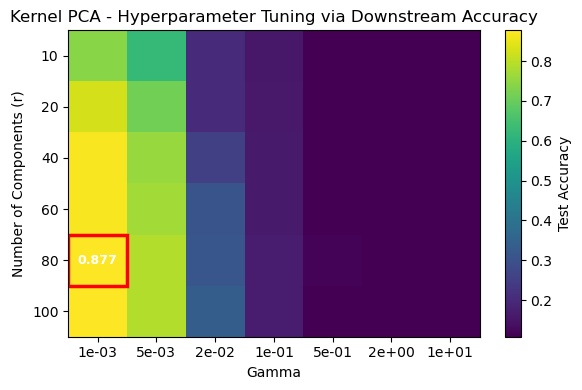

Best performance: r=80, gamma=1.00e-03, Accuracy=0.8770


In [22]:
# --- Heatmap visualization ---
r_vals = sorted(set(r_list))
gamma_vals = sorted(set(gamma_list))
acc_matrix = np.zeros((len(r_vals), len(gamma_vals)))

for r, g, acc in results:
    i = r_vals.index(r)
    j = gamma_vals.index(g)
    acc_matrix[i, j] = acc

# Find best cell
best_idx = np.unravel_index(np.argmax(acc_matrix), acc_matrix.shape)
best_r_idx, best_g_idx = best_idx
best_acc = acc_matrix[best_r_idx, best_g_idx]
best_r = r_vals[best_r_idx]
best_g = gamma_vals[best_g_idx]

# --- Plot ---
plt.figure(figsize=(6,4))
plt.imshow(acc_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label="Test Accuracy")
plt.xticks(range(len(gamma_vals)), [f"{g:.0e}" for g in gamma_vals])
plt.yticks(range(len(r_vals)), r_vals)
plt.xlabel("Gamma")
plt.ylabel("Number of Components (r)")
plt.title("Kernel PCA - Hyperparameter Tuning via Downstream Accuracy")

# Highlight best cell with a red rectangle
ax = plt.gca()
rect = Rectangle(
    (best_g_idx - 0.5, best_r_idx - 0.5),
    1, 1,
    linewidth=2.5,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)

# Annotate the best value
plt.text(
    best_g_idx, best_r_idx,
    f"{best_acc:.3f}",
    color='white', fontsize=9, ha='center', va='center', fontweight='bold'
)

plt.tight_layout()
plt.savefig("docs/kernelpca_hyperparam_heatmap.png", dpi=150)
plt.show()

print(f"Best performance: r={best_r}, gamma={best_g:.2e}, Accuracy={best_acc:.4f}")


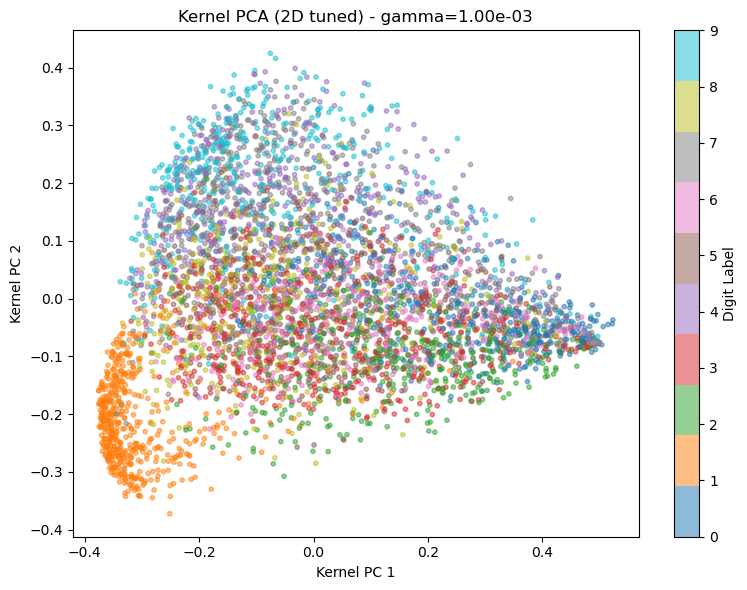

In [ ]:
# We know the best value of Gamma - so can plot first 2 components (note not necessarily the best components because kernel PCA is not nested or ordered)
X_scaled_sub = StandardScaler().fit_transform(X_sub)
gamma = 1e-03
Z2 = KernelPCA(n_components=2, kernel='rbf', gamma=gamma, random_state=random_state).fit_transform(X_scaled_sub)

# plot the 2D-optimized embedding
plt.figure(figsize=(8,6))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=y_sub, cmap="tab10", s=10, alpha=0.5)
plt.colorbar(sc, label="Digit Label")
plt.xlabel("Kernel PC 1")
plt.ylabel("Kernel PC 2")
plt.title(f"Kernel PCA (2D tuned) - gamma={gamma:.2e}")
plt.tight_layout()
plt.savefig("docs/kernelpca12_labeled_2d_tuned.png")
plt.show()
